# **Predicting the perception of deprivation from VHR Satelite Images.**

## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py

In [2]:
from IPython.display import clear_output

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras import backend as K

Check the version of Tensorflow. It should be 2.8.0

In [5]:
print(tf.__version__)

2.8.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [6]:
! nvidia-smi

Mon Mar 14 17:35:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 27%   46C    P0    55W / 250W |      0MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 16%   

Configure Tensorflow (v2.8) for deterministic behavior (to get reproducible results). See official manual [HERE](https://www.tensorflow.org/api_docs/python/tf/config/experimental/enable_op_determinism). NOTICE: Has never worked properly :/

In [7]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
# Enable determinism was not possible in this context of fine-tuning of model with BatchNorm weights should be kept on inference mode with training=False.
# It rased the error "A deterministic GPU implementation of fused batch-norm backprop, when training is disabled, is not currently available."
# See official Keras documentation on this point: https://keras.io/guides/transfer_learning/

#tf.config.experimental.enable_op_determinism()

Setup Keras to work with Mixed Precision to speed up the learning process and reduce GPU memory required. More information [HERE](https://keras.io/api/mixed_precision/).

In [9]:
# Setup Keras Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


Import custom functions

In [10]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [11]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file

Test is GPU(s) is(are) available for processing and measure the speed-up of using it(them). 

In [12]:
%run ../SRC/Check_GPU_available.py

2 Physical GPUs, 2 Logical GPUs
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.167665365152061
GPU (s):
0.036765226162970066
GPU speedup over CPU: 31x


# 1. Data preparation 

**In this part, we load the data prepared before.**

In [63]:
# Set ID of experiment
experiment_id = 14

In [64]:
# Define working path 
root = "/home/tgrippa/PARTIMAP_processing"
#data_path = os.path.join(root, "data_p3_outliers_7030")
#data_path = os.path.join(root, "data_p3_outliers_8020")
#data_path = os.path.join(root, "data_p3_outliers_9010")
data_path = os.path.join(root, "data_p3_outliers_kfold10")
output_path = os.path.join(root, "output_VGG_exp_%s" %experiment_id)
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [65]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_14' has been created
The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_14/model' has been created
The folder '/home/tgrippa/PARTIMAP_processing/output_DenseNet_exp_14/results' has been created
The folder '/home/tgrippa/PARTIMAP_processing/data_p3_outliers_9010' already exists


In [ ]:
# Read the dataset from HDF5 file
idx_train = []
idx_val = []
with h5py.File(os.path.join(data_path,"RGNIR_224.hdf5"), mode="r") as f:
#with h5py.File(os.path.join(data_path,"RGB_224.hdf5"), mode="r") as f:
    stack = np.asarray(f["stack"])
    scores = np.asarray(f["scores"])
    photo_id = np.asarray(f["photo_id"])
    for i in f['idx_train'].keys():      
        idx_train.append(np.asarray(f['idx_train'][i]))
    for i in f['idx_val'].keys():      
        idx_val.append(np.asarray(f['idx_val'][i]))

In [ ]:
# Check the shape of each sub-dataset 
fold = 1
for t,v in zip(idx_train,idx_val):
    print("----- Fold %s -----" %fold)
    print("Train %s   Val %s" %(t.shape,v.shape))    
    fold += 1

In [ ]:
# Random selection
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(15, 15))
for i in range(3):
    rd_img = np.random.randint(1,500)
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Norma_Xpercentile(stack[rd_img,:,:,:]))
    plt.axis("off")
    plt.title("Random indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd_img,photo_id[rd_img],scores[rd_img]))
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

# 2 Model definition
In this part, we use a network pre-trained on ImageNet to predict the deprivation degree. We droped the classification head and plugged a regression head on it. Then, we fine-tune weights on our own data.
Since Tensorflow is difficult to configure to avoid stochiastic behaviour [(Alahmari et al. 2020)](https://ieeexplore.ieee.org/document/9266043/), the implement a multiple run approach. 

### 2.1 Data Augmentation Definition

In [68]:
# Set Image Data Generator
datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect'
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


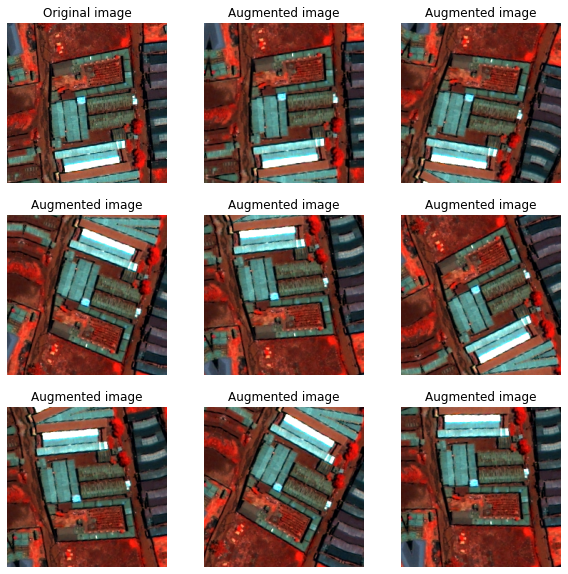

In [69]:
# Visualize the augmented data for an original image (in top left corner)
img_idx = 154
plt.rcParams["figure.facecolor"] = 'w'
pic = datagen.flow(np.expand_dims(x_train[img_idx], axis=0), batch_size =1, seed=3) 
plt.figure(figsize=(10, 10))
for i in range(9):
    if i==0:
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[img_idx]))
        plt.axis("off")
        plt.title("Original image")
    else:
        ax = plt.subplot(3, 3, i + 1)
        batch = pic.next()
        plt.imshow(Norma_Xpercentile(batch[0]))
        plt.axis("off")
        plt.title("Augmented image")
plt.savefig(os.path.join(model_path,'Data_augmentation.png'), dpi=300, bbox_inches='tight')

### 2.2 Models Architecture Definition

**DenseNet121**

In [70]:
## DenseNet121 model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [72]:
def DenseNet121_model(inputshape=(224,224,3)):    
    # Create the base pre-trained model without the classification head
    base_model = DenseNet121(input_shape=inputshape, weights='imagenet', include_top=False)  
    inputs = keras.Input(shape=inputshape)
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # add dropout as regulariser to avoid overfit
    x = Dropout(0.5)(x)
    # and a linear activation layer with 1 neuron for the regression
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    return base_model, model

In [73]:
class mutli_run():
    
    def __init__(self, nbrun, lr, earlypatience, reduceplateau, bsize, nb_epochs, datagen, outputfolder):
        self.nbrun = nbrun
        self.lr = lr
        self.earlypatience = earlypatience
        self.reduceplateau = reduceplateau
        self.bsize = bsize
        self.nb_epochs = nb_epochs
        self.datagen = datagen
        self.outputfolder = outputfolder

    def run(self):        
        # Save current time for time management
        starttime = start_processing()
        # Create folder for the multirun 
        check_create_dir(self.outputfolder)
        # Create a table (pandas dataframe) to store the multiple run values
        mutlirun_table = pd.DataFrame(columns = ["Run", "Run_dir", "Weight_file", "RunTime", "Epochs", "R2_train", "rmse_train", "mae_train", "R2_test", "rmse_test", "mae_test"],dtype=object)
        # Create a list of history
        multirun_histories = []
        self.multirun_histories = multirun_histories
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()
        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
        
        for i in range(1,self.nbrun+1):    
            # Clear session to avoid increasing the memory usage after each loop
            tf.keras.backend.clear_session()
            # Clear the output of the previous loop
            clear_output(wait=True)
            # Print current loop number
            print("\nStarting run {}/{}...".format(i,self.nbrun))
            # Save current time for time management
            starttime = time.time()
            
            # Define callbacks for this run (needed to reinitialise at least the checkpoint from the previous run)
            checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
            checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
            tmp_csv_path = os.path.join(tempfile.gettempdir(), "run_log.csv")
            csv_logger = tf.keras.callbacks.CSVLogger(tmp_csv_path, separator=";", append=True)
            callbacklist = [checkpoint, csv_logger]
            if self.reduceplateau:
                reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=self.reduceplateau, verbose=1, mode='auto', cooldown=0, min_lr=0)
                callbacklist.append(reduce)
            if self.earlypatience:
                early = EarlyStopping(monitor="val_loss",mode="min",patience=self.earlypatience) # probably needs to be more patient
                callbacklist.append(early)                
               
            # Stage A - train the model on the new data for a few epochs, just to retrain the regression layer at the end of the model
            # Open a strategy scope.
            with strategy.scope():
                # Create a new instance of the model
                # Define a new instance of the model - Reinitialise model between diferent runs
                base_model, model = DenseNet121_model(inputshape=(224,224,3))
                # first: train only the top layers (which were randomly initialized)
                # i.e. freeze all convolutional DenseNet121 layers
                base_model.trainable = False
                # Optimizer and learning rate    
                opt = Adam(learning_rate=1e-3)  #For the first part of the fine-tuning we use lr=1e-3
                # Compile the model with LOSS, Optimizer, metrics
                model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
            # Train the model 
            nb_epochs = 15
            history = model.fit(
                self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                steps_per_epoch=int(len(x_train)/self.bsize),
                validation_data = (x_test,y_test),
                epochs = nb_epochs)                   
                
            # Stage B - Unfroze the pre-trained weights and fine-tuned weights with a very small learning rate
            # Open a strategy scope.
            with strategy.scope():
                # Make the base model layers trainable and recompile to makes changes works. Learning rate is reduced to not destroy all the pre-trained weights
                base_model.trainable = True
                model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=self.lr),   # Very small learning rate to fine-tune the weights pretrained on ImageNet
                              metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination])
            # Train the model 
            history = model.fit(
                self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                steps_per_epoch=int(len(x_train)/self.bsize),
                validation_data = (x_test,y_test),
                epochs = self.nb_epochs, 
                callbacks = callbacklist
            )          

            # Save processing time
            training_time = round((time.time() - starttime)/60,1)
            
            # Append the run history to the multirun_hostories list
            multirun_histories.append(history)
            
            # Load the weights from the best checkpoint
            model.load_weights(checkpoint_filepath)
            # run the model on the train and test datasets 
            y_pred_test = model.predict(x_test) 
            y_pred_train = model.predict(x_train)

            # Calculate the R2 Score and RMSE
            R2_train = r2_score(y_train, y_pred_train)
            rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
            mae_train = mean_absolute_error(y_train, y_pred_train)
            R2_test = r2_score(y_test,y_pred_test)
            rmse_test = mean_squared_error(y_test, y_pred_test,squared=False) 
            mae_test = mean_absolute_error(y_test, y_pred_test) 

            # Create folder for this run 
            base_name = "val_%0.2f_test_%0.2f" %(R2_train,R2_test)
            runfolder = os.path.join(self.outputfolder, base_name)
            check_create_dir(runfolder)

            # Move tmp LOGGER files to run directory
            shutil.move(tmp_csv_path, os.path.join(runfolder, "run_log.txt"))
            
            # Write metrics on the run log file
            log_path = os.path.join(runfolder, "run_metrics_%s.txt" %base_name)
            write_run_metrics_file(log_path,R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test)
            
            # Save predictions
            save_path = os.path.join(runfolder, "predictions_%s.hdf5" %base_name)
            save_predictions(save_path,y_pred_test,y_pred_train)
            
            # Save model weight in the right folder and remote the temporary folder for the ModelCheckpoint
            weight_file = os.path.join(runfolder,'Best_checkoint_%s.hdf5' %base_name)
            shutil.move(checkpoint_filepath, weight_file)
            try:
                shutil.rmtree(os.path.split(checkpoint_filepath)[0])
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
            
            # Plots
            plot_loss(history, os.path.join(runfolder,"Loss_MSE_%s.png" %base_name), show=False)
            plot_pred_train(y_train, y_pred_train, R2_train, rmse_train, mae_train, os.path.join(runfolder,"mae_train_%s.png" %base_name), show=False)
            plot_pred_test(y_test, y_pred_test, R2_test, rmse_test, mae_test, os.path.join(runfolder,"mae_test_%s.png" %base_name), show=False)
            
            # Add metrics of the run to the summary table
            run_metrics = pd.Series([i,runfolder,weight_file,training_time,len(history.history['loss']),R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test], index=mutlirun_table.columns)
            mutlirun_table = mutlirun_table.append(run_metrics, ignore_index=True)
            
        # Create and save the plot loss of multirun
        plot_loss_multirun(mutlirun_instance.multirun_histories, os.path.join(self.outputfolder,'multirun_plot.png'), show=False)
        # Sort the summary table with R2_test descending and save the table to the mutlirun folder
        mutlirun_table.sort_values("R2_test", ascending=False, inplace=True)
        mutlirun_table.reset_index(inplace=True)
        mutlirun_table.to_csv(os.path.join(self.outputfolder,'multirun_table.csv'), index=False)
        self.mutlirun_table = mutlirun_table
        # Compute mean and standard deviation of the runs
        mutlirun_summary = pd.DataFrame()
        mutlirun_summary['Mean'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_dir','Weight_file'])].mean()
        mutlirun_summary['Std'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_di','weight_file'])].std()
        mutlirun_summary.to_csv(os.path.join(self.outputfolder,'multirun_summary.csv'), index=True)
        self.mutlirun_summary = mutlirun_summary
        ## Print processing time
        print_processing_time(starttime ,"Multirun process achieved in ")

In [73]:
class mutli_run_cv():
    
    def __init__(self, kf_train, kf_val, lr, earlypatience, reduceplateau, bsize, nb_epochs, datagen, outputfolder):
        self.kf_train = kf_train
        self.kf_val = kf_val
        self.lr = lr
        self.earlypatience = earlypatience
        self.reduceplateau = reduceplateau
        self.bsize = bsize
        self.nb_epochs = nb_epochs
        self.datagen = datagen
        self.outputfolder = outputfolder

    def run(self):        
        # Save current time for time management
        starttime = start_processing()
        # Create folder for the multirun 
        check_create_dir(self.outputfolder)
        # Create a table (pandas dataframe) to store the multiple run values
        mutlirun_table = pd.DataFrame(columns = ["Run", "Run_dir", "Weight_file", "RunTime", "Epochs", 
                                                 "R2_train", "rmse_train", "mae_train", 
                                                 "R2_val", "rmse_val", "mae_val"],dtype=object)
        # Create a list of history
        multirun_histories = []
        self.multirun_histories = multirun_histories
        # Create a MirroredStrategy.
        strategy = tf.distribute.MirroredStrategy()
        print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
        
        # Mutlirun with K-fold cross validation 
        fold_no = 1
        for train_index, val_index in zip(self.kf_train,self.kf_val):
            # Clear session to avoid increasing the memory usage after each loop
            tf.keras.backend.clear_session()
            # Clear the output of the previous loop
            clear_output(wait=True)
            # Print current loop number
            print("\nStarting fold {}/{}...".format(fold_no,len(self.kf_train)))
            # Save current time for time management
            starttime = time.time()
            
            # Select the current train/val fold 
            x_train = stack[list(train_index),:,:,:]  #Training images
            y_train = scores[list(train_index)]  #Training labels
            x_val = stack[list(val_index),:,:,:]  #Validation images
            y_val = scores[list(val_index)]  #Validation labels
            
            # Define callbacks for this run (needed to reinitialise at least the checkpoint from the previous run)
            checkpoint_filepath = os.path.join(tempfile.mkdtemp(),'Best_performed_model.hdf5')
            checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
            tmp_csv_path = os.path.join(tempfile.gettempdir(), "run_log.csv")
            csv_logger = tf.keras.callbacks.CSVLogger(tmp_csv_path, separator=";", append=True)
            callbacklist = [checkpoint, csv_logger]
            if self.reduceplateau:
                reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=self.reduceplateau, verbose=1, mode='auto', cooldown=0, min_lr=0)
                callbacklist.append(reduce)
            if self.earlypatience:
                early = EarlyStopping(monitor="val_loss",mode="min",patience=self.earlypatience) # probably needs to be more patient
                callbacklist.append(early)                
               
            # Stage A - train the model on the new data for a few epochs, just to retrain the regression layer at the end of the model
            # Open a strategy scope.
            with strategy.scope():
                # Create a new instance of the model
                # Define a new instance of the model - Reinitialise model between diferent runs
                base_model, model = DenseNet121_model(inputshape=(224,224,3))
                # first: train only the top layers (which were randomly initialized)
                # i.e. freeze all convolutional DenseNet121 layers
                base_model.trainable = False
                # Optimizer and learning rate    
                opt = Adam(learning_rate=1e-3)  #For the first part of the fine-tuning we use lr=1e-3
                # Compile the model with LOSS, Optimizer, metrics
                model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 
            # Train the model 
            nb_epochs = 15
            history = model.fit(
                self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                steps_per_epoch=int(len(x_train)/self.bsize),
                validation_data = (x_val,y_val),
                epochs = nb_epochs)                   
                
            # Stage B - Unfroze the pre-trained weights and fine-tuned weights with a very small learning rate
            # Open a strategy scope.
            with strategy.scope():
                # Make the base model layers trainable and recompile to makes changes works. Learning rate is reduced to not destroy all the pre-trained weights
                base_model.trainable = True
                model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=self.lr),   # Very small learning rate to fine-tune the weights pretrained on ImageNet
                              metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination])
            # Train the model 
            history = model.fit(
                self.datagen.flow(x_train, y_train, batch_size=self.bsize, shuffle=False, seed=3),
                steps_per_epoch=int(len(x_train)/self.bsize),
                validation_data = (x_val,y_val),
                epochs = self.nb_epochs, 
                callbacks = callbacklist)          

            # Save processing time
            training_time = round((time.time() - starttime)/60,1)
            
            # Append the run history to the multirun_hostories list
            multirun_histories.append(history)
            
            # Load the weights from the best checkpoint
            model.load_weights(checkpoint_filepath)
            # run the model on the train and test datasets 
            y_pred_train = model.predict(x_train)
            y_pred_val = model.predict(x_val) 

            # Calculate the R2 Score and RMSE
            R2_train = r2_score(y_train, y_pred_train)
            rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
            mae_train = mean_absolute_error(y_train, y_pred_train)
            R2_val = r2_score(y_val,y_pred_val)
            rmse_val = mean_squared_error(y_val, y_pred_val,squared=False) 
            mae_val = mean_absolute_error(y_val, y_pred_val)

            # Create folder for this run 
            base_name = "kf_%s_train_%0.2f_val_%0.2f" %(fold_no,R2_train,R2_val)
            runfolder = os.path.join(self.outputfolder, base_name)
            check_create_dir(runfolder)

            # Move tmp LOGGER files to run directory
            shutil.move(tmp_csv_path, os.path.join(runfolder, "run_log.txt"))
            
            # Write metrics on the run log file
            log_path = os.path.join(runfolder, "run_metrics_%s.txt" %base_name)
            write_run_metrics_file(log_path,R2_train,rmse_train,mae_train,R2_val,rmse_val,mae_val)
            
            # Save predictions
            save_path = os.path.join(runfolder, "predictions_%s.hdf5" %base_name)
            save_predictions(save_path,y_pred_val,y_pred_train)
            
            # Save model weight in the right folder and remote the temporary folder for the ModelCheckpoint
            weight_file = os.path.join(runfolder,'Best_checkoint_%s.hdf5' %base_name)
            shutil.move(checkpoint_filepath, weight_file)
            try:
                shutil.rmtree(os.path.split(checkpoint_filepath)[0])
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
            
            # Plots
            plot_loss(history, os.path.join(runfolder,"Loss_MSE_%s.png" %base_name), show=False)
            plot_pred_train(y_train, y_pred_train, R2_train, rmse_train, mae_train, os.path.join(runfolder,"mae_train_%s.png" %base_name), show=False)
            plot_pred_test(y_val, y_pred_val, R2_val, rmse_val, mae_val, os.path.join(runfolder,"mae_val_%s.png" %base_name), show=False)
            
            # Add metrics of the run to the summary table
            run_metrics = pd.Series([fold_no,runfolder,weight_file,training_time,len(history.history['loss']),
                                     R2_train,rmse_train,mae_train,
                                     R2_val,rmse_val,mae_val], index=mutlirun_table.columns)
            mutlirun_table = mutlirun_table.append(run_metrics, ignore_index=True)
            
            # Increase fold number
            fold_no = fold_no + 1
            
        # Create and save the plot loss of multirun
        plot_loss_multirun(mutlirun_instance.multirun_histories, os.path.join(self.outputfolder,'multirun_plot.png'), show=False)
        # Sort the summary table with R2_test descending and save the table to the mutlirun folder
        mutlirun_table.sort_values("R2_val", ascending=False, inplace=True)
        mutlirun_table.reset_index(inplace=True)
        mutlirun_table.to_csv(os.path.join(self.outputfolder,'multirun_table.csv'), index=False)
        self.mutlirun_table = mutlirun_table
        # Compute mean and standard deviation of the runs
        mutlirun_summary = pd.DataFrame()
        mutlirun_summary['Mean'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_dir','Weight_file'])].mean()
        mutlirun_summary['Std'] = mutlirun_table.loc[:, ~mutlirun_table.columns.isin(['Run','Run_di','weight_file'])].std()
        mutlirun_summary.to_csv(os.path.join(self.outputfolder,'multirun_summary.csv'), index=True)
        self.mutlirun_summary = mutlirun_summary
        ## Print processing time
        print_processing_time(starttime ,"Multirun process achieved in ")

# 3 Train model

## 3.1 K-Fold cross-validation

In [74]:
# Define hyperparameter
bsize = 128
nb_epochs = 200
early_patience = 50
reduceplateau = 20
nb_multirun = 5
lr_ft2 = 1e-4

In [75]:
multirun_dir = os.path.join(output_path,"results_mutlirun_%sepochs_%sbsize_Early%s" %(nb_epochs,bsize,early_patience))
mutlirun_instance = mutli_run(idx_train, idx_val, lr_ft2, early_patience, reduceplateau, bsize, nb_epochs, datagen, multirun_dir)

In [76]:
mutlirun_instance.run()


Starting run 5/5...
Epoch 1/15
14/14 [==============================] - 37s 1s/step - loss: 430.9218 - mean_absolute_error: 18.4698 - root_mean_squared_error: 20.7583 - coeff_determination: -295.2765 - val_loss: 105.1850 - val_mean_absolute_error: 9.3785 - val_root_mean_squared_error: 10.2561 - val_coeff_determination: -68.4443
Epoch 2/15
14/14 [==============================] - 13s 1s/step - loss: 31.6811 - mean_absolute_error: 4.5620 - root_mean_squared_error: 5.6286 - coeff_determination: -27.4014 - val_loss: 15.1573 - val_mean_absolute_error: 3.2679 - val_root_mean_squared_error: 3.8933 - val_coeff_determination: -9.9195
Epoch 3/15
14/14 [==============================] - 13s 919ms/step - loss: 12.0649 - mean_absolute_error: 2.7096 - root_mean_squared_error: 3.4734 - coeff_determination: -6.8155 - val_loss: 6.4025 - val_mean_absolute_error: 2.0410 - val_root_mean_squared_error: 2.5303 - val_coeff_determination: -3.3928
Epoch 4/15
14/14 [==============================] - 13s 910ms/

In [77]:
# Print the multirun table
mutlirun_instance.mutlirun_table

,index,Run,Run_dir,Weight_file,RunTime,Epochs,R2_train,rmse_train,mae_train,R2_test,rmse_test,mae_test
0,0,1,/home/tgrippa/PARTIMAP_processing/output_Dense...,/home/tgrippa/PARTIMAP_processing/output_Dense...,50.8,200,0.870099,0.623812,0.496537,0.833907,0.687540,0.545842
1,1,2,/home/tgrippa/PARTIMAP_processing/output_Dense...,/home/tgrippa/PARTIMAP_processing/output_Dense...,51.0,200,0.895562,0.559342,0.444096,0.827427,0.700824,0.565032
2,3,4,/home/tgrippa/PARTIMAP_processing/output_Dense...,/home/tgrippa/PARTIMAP_processing/output_Dense...,41.7,160,0.875851,0.609846,0.482560,0.826541,0.702621,0.562888
3,2,3,/home/tgrippa/PARTIMAP_processing/output_Dense...,/home/tgrippa/PARTIMAP_processing/output_Dense...,47.1,185,0.873336,0.615991,0.491065,0.820008,0.715730,0.561679
4,4,5,/home/tgrippa/PARTIMAP_processing/output_Dense...,/home/tgrippa/PARTIMAP_processing/output_Dense...,50.7,200,0.863990,0.638313,0.508345,0.818325,0.719067,0.564844


In [78]:
# Print the multirun summary
mutlirun_instance.mutlirun_summary

,Mean,Std
index,2.000000,1.581139
RunTime,48.260000,4.009115
Epochs,189.000000,17.464249
R2_train,0.875768,0.011922
rmse_train,0.609461,0.029971
mae_train,0.484521,0.024458
R2_test,0.825241,0.006261
rmse_test,0.705156,0.012657
mae_test,0.560057,0.008068


# 4 Display results

## 4.1 Display results of the best run

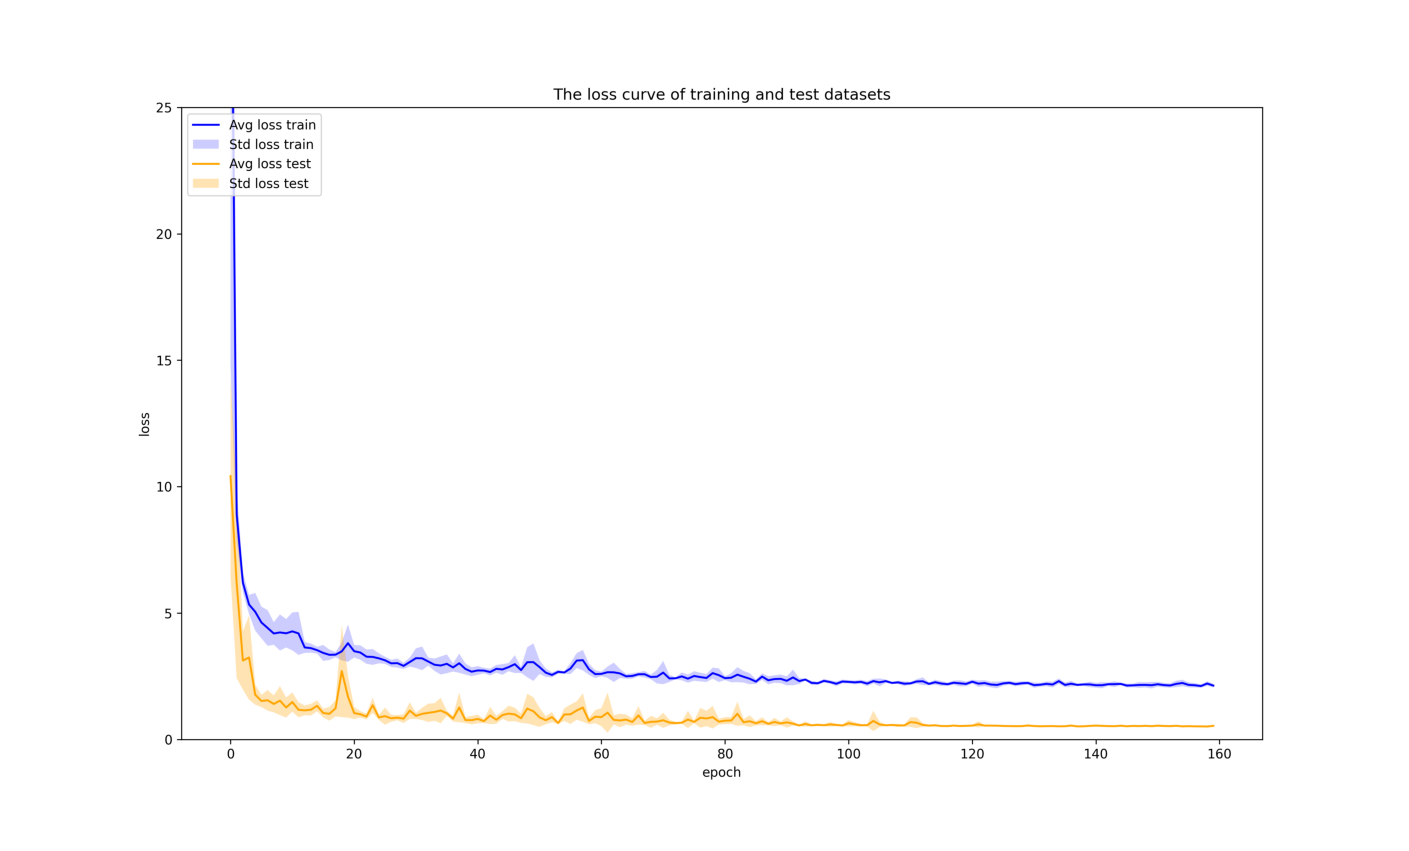

In [79]:
img = mpimg.imread(glob.glob(os.path.join(multirun_dir,'multirun_plot*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

In [80]:
# Best run weights
multirun_best_weight = mutlirun_instance.mutlirun_table["Weight_file"][0]
multirun_best_dir = mutlirun_instance.mutlirun_table["Run_dir"][0]

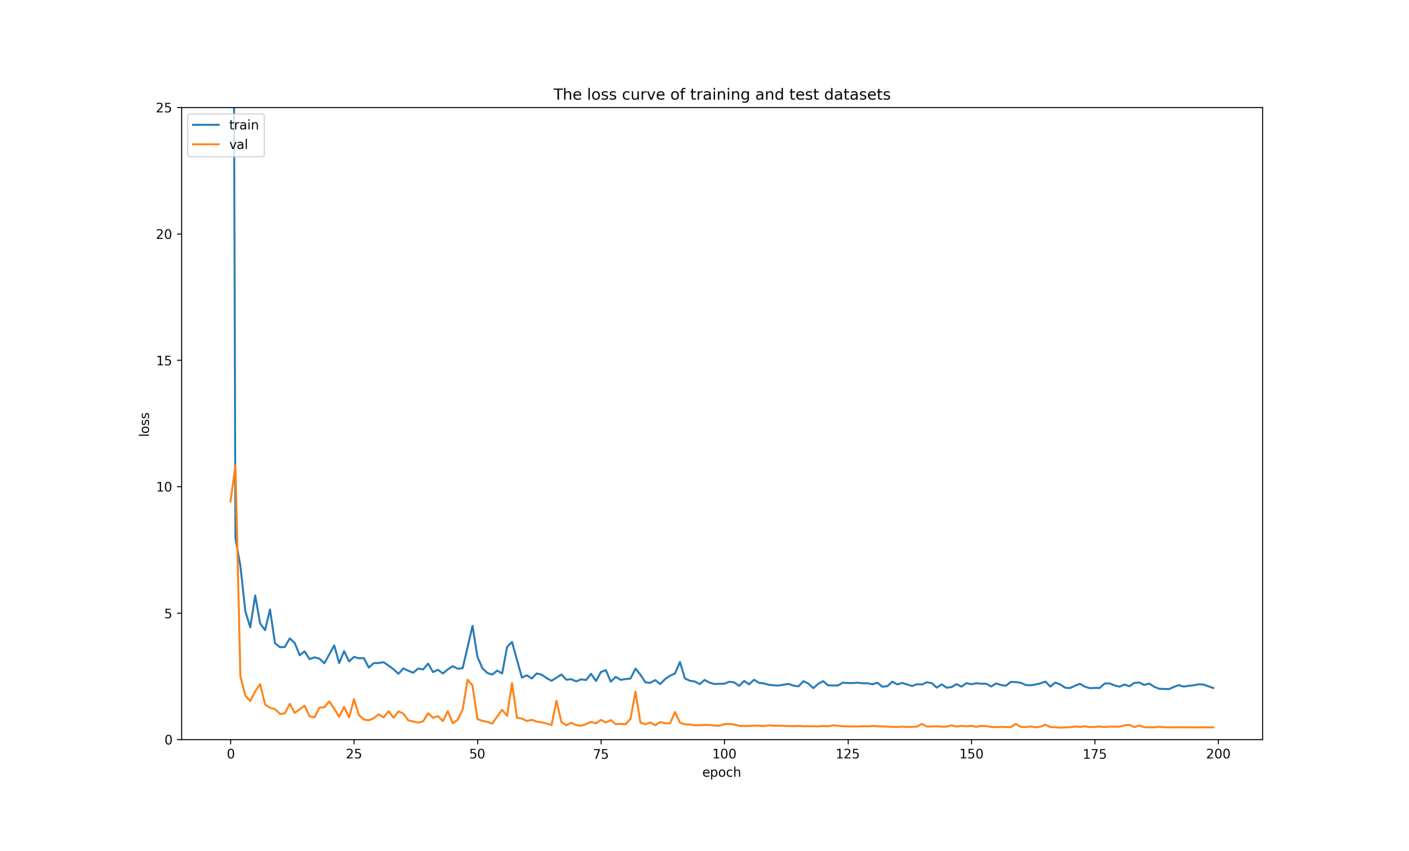

In [81]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'Loss_MSE_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

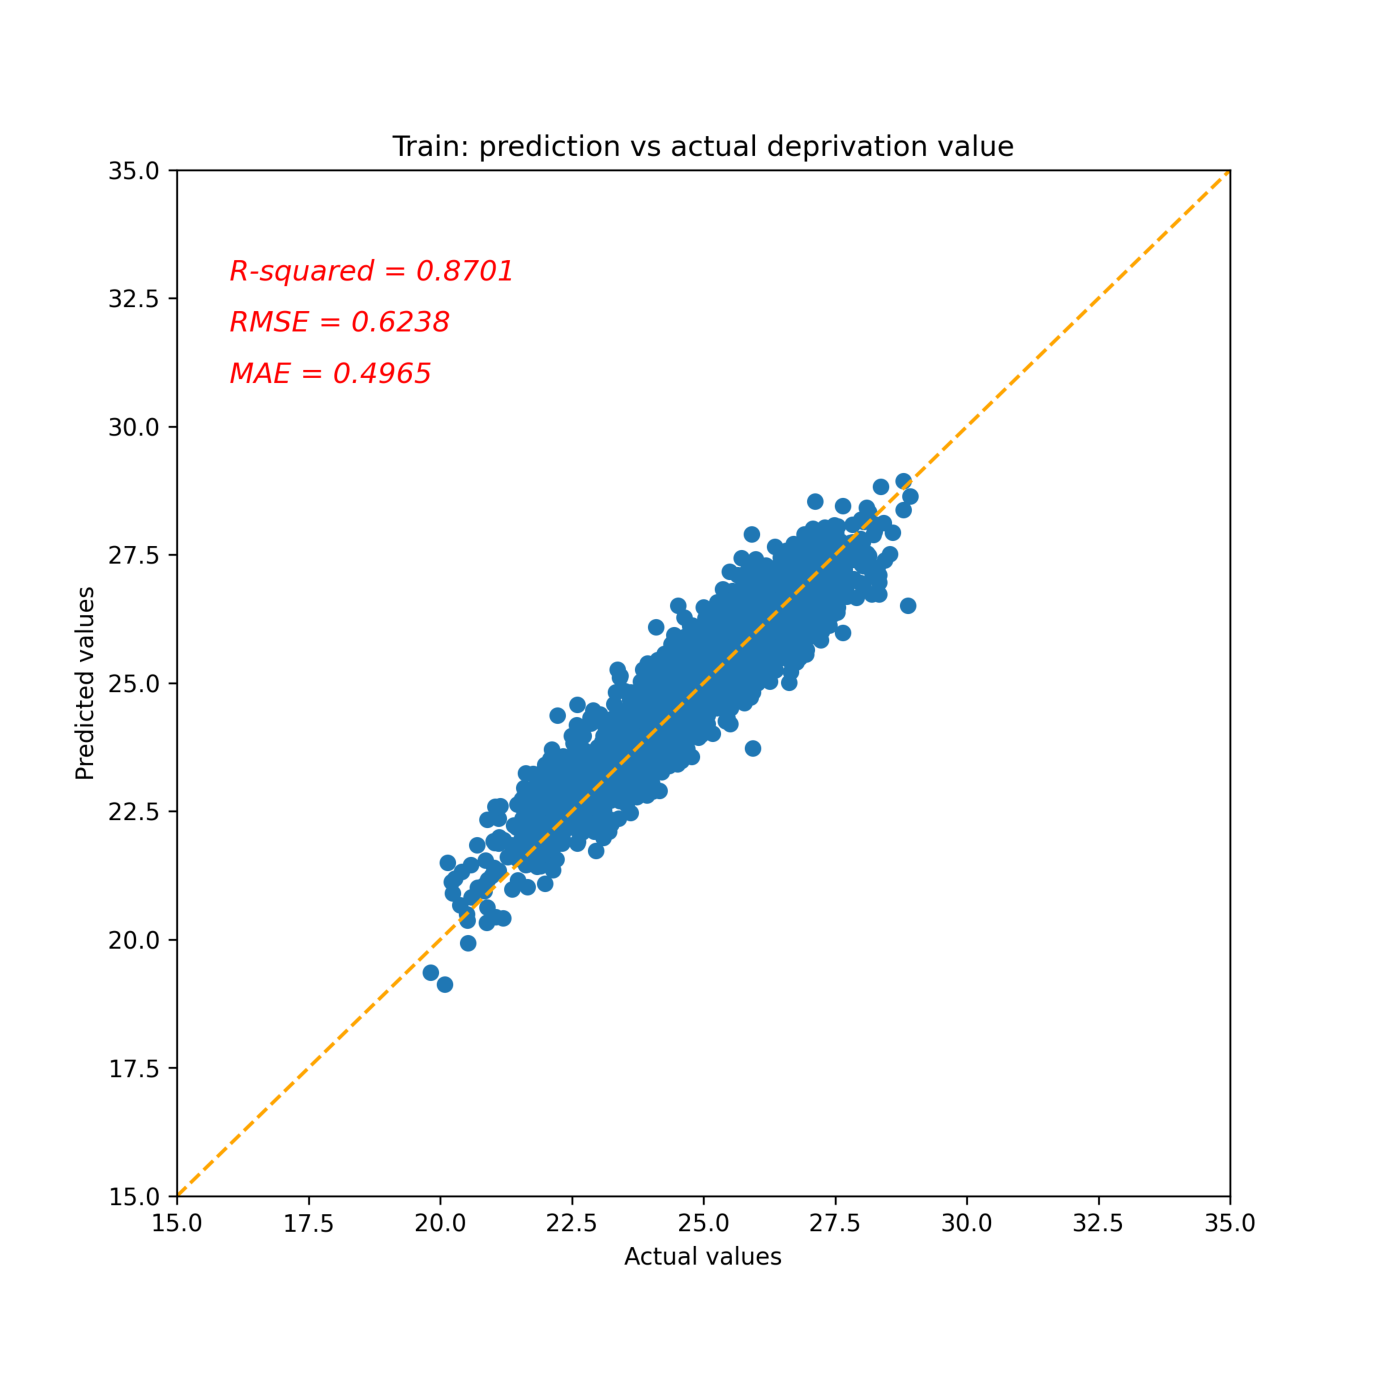

In [82]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'mae_train_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

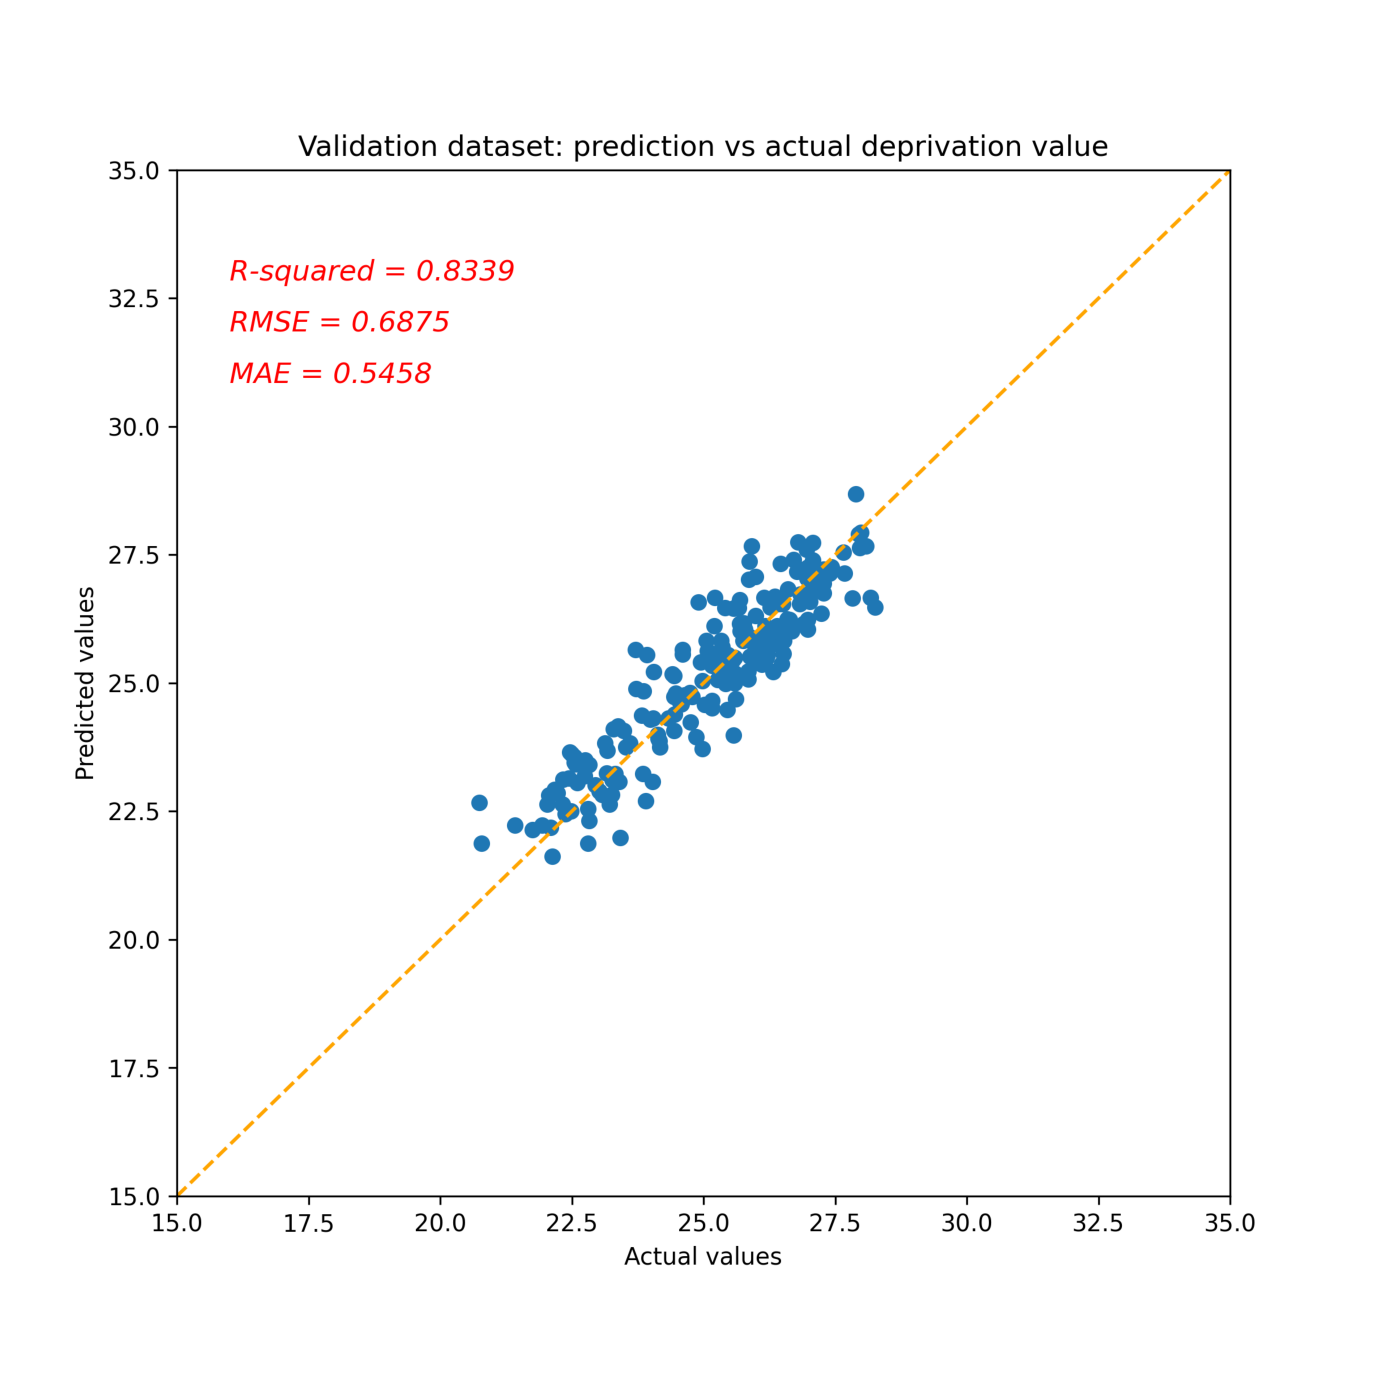

In [83]:
img = mpimg.imread(glob.glob(os.path.join(multirun_best_dir,'mae_val_*.png'))[0])
plt.figure(figsize = (25,25))
plt.axis("off")
plt.imshow(img)
plt.show()

## 4.2 Visualize the best and worse predictions

In [84]:
# Load the predictions of the best run
with h5py.File(glob.glob(os.path.join(multirun_best_dir,'predictions_*.hdf5'))[0], mode="r") as f:
    y_pred_test = np.asarray(f["y_pred_test"])

In [ ]:
multirun_best_fold = mutlirun_instance.mutlirun_table["index"][0]
x_val = stack[list(idx_val[multirun_best_fold]),:,:,:]  #Validation images
y_val = scores[list(idx_val[multirun_best_fold])]  #Validation images
val_ID = photo_id[list(idx_val[multirun_best_fold])]

In [85]:
# Get list of image id and corresponding Absolute Error
pred_val_score = [(x[0],x[1],x[2][0],x[3][0],x[2][0]-x[3][0],np.abs(x[2][0]-x[3][0])) for x in zip(val_ID.tolist(),x_val.tolist(),y_pred_test.tolist(),y_val.tolist())]
pred_val_score = sorted(pred_val_score, key=lambda x: x[5]) #idx0:PartimapID, idx1:Image, idx2:Ypred, idx3:Y, idx4:Error, idx5:AbsError  -- Sort by AbsError 
pred_val_score_bestworse = []
[pred_val_score_bestworse.append(x) for x in pred_val_score[:5]] #Best 
[pred_val_score_bestworse.append(x) for x in pred_val_score[-5:]] #Worse

[None, None, None, None, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

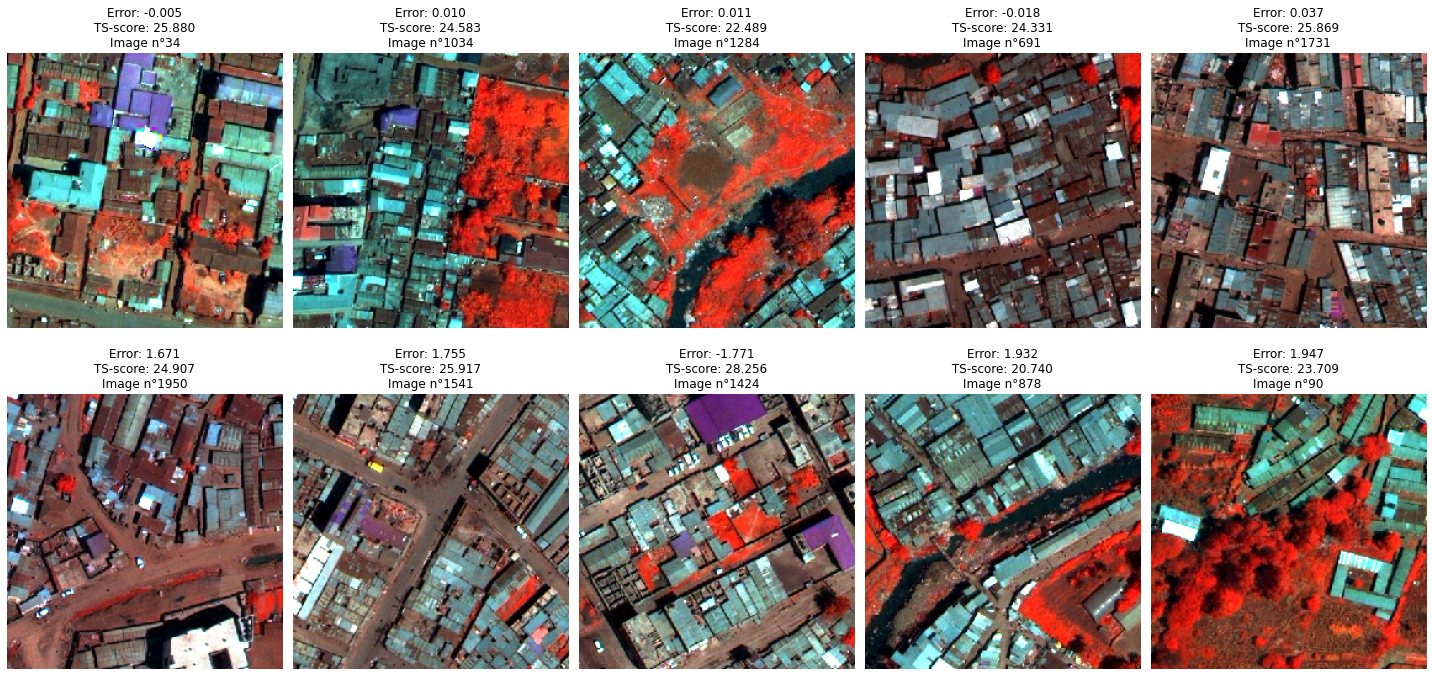

In [86]:
# Visualize the best and worse predictions
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(20, 10))
for i in range(len(pred_val_score_bestworse)):
    if i<=4:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][1])))
        plt.axis("off")
        plt.title("Error: %0.3f\n TS-score: %0.3f \nImage n°%s"%(pred_val_score_bestworse[i][4],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
    else:
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(Norma_Xpercentile(np.array(pred_val_score_bestworse[i][1])))
        plt.axis("off")
        plt.title("Error: %0.3f\n TS-score: %0.3f \nImage n°%s"%(pred_val_score_bestworse[i][4],pred_val_score_bestworse[i][3],pred_val_score_bestworse[i][0]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 
plt.savefig(os.path.join(results_path,'Best_Worse_Prediction.png'), dpi=300, bbox_inches='tight')